In [1]:
# Install required packages
!pip install tensorflow matplotlib scikit-learn


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import MeanIoU


In [3]:
# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_IMAGES = 100

# Arrays for images and masks
images = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
masks = np.zeros((NUM_IMAGES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Create random "flood regions" (circles)
for i in range(NUM_IMAGES):
    x, y = np.random.randint(32, 96, size=2)
    r = np.random.randint(10, 30)
    yy, xx = np.meshgrid(np.arange(IMG_HEIGHT), np.arange(IMG_WIDTH))
    circle = ((xx - x)**2 + (yy - y)**2) <= r**2

    # Random background
    images[i] = np.random.rand(IMG_HEIGHT, IMG_WIDTH, 3)

    # Mask
    masks[i, circle, 0] = 1.0

print("Images shape:", images.shape, "Masks shape:", masks.shape)


Images shape: (100, 128, 128, 3) Masks shape: (100, 128, 128, 1)


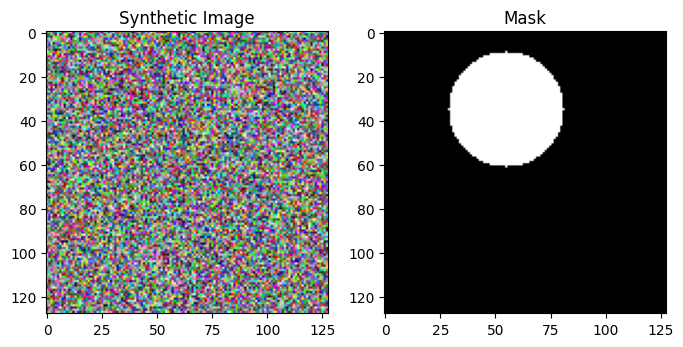

In [4]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.title("Synthetic Image")
plt.subplot(1,2,2)
plt.imshow(masks[0].squeeze(), cmap='gray')
plt.title("Mask")
plt.show()


In [5]:
def unet_model(input_size=(128,128,3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.UpSampling2D()(c3)
    u1 = layers.Concatenate()([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

# Create and compile model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 128, 128,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,273 (462.00 KB)

 Trainable params: 118,273 (462.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=8,
    epochs=5
)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8424 - loss: 0.5805 - val_accuracy: 0.9148 - val_loss: 0.3141
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 867ms/step - accuracy: 0.9266 - loss: 0.2908 - val_accuracy: 0.9148 - val_loss: 0.3100
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 987ms/step - accuracy: 0.9202 - loss: 0.2917 - val_accuracy: 0.9148 - val_loss: 0.2958
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 996ms/step - accuracy: 0.9217 - loss: 0.2707 - val_accuracy: 0.9148 - val_loss: 0.2677
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9255 - loss: 0.2452 - val_accuracy: 0.9148 - val_loss: 0.2689


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


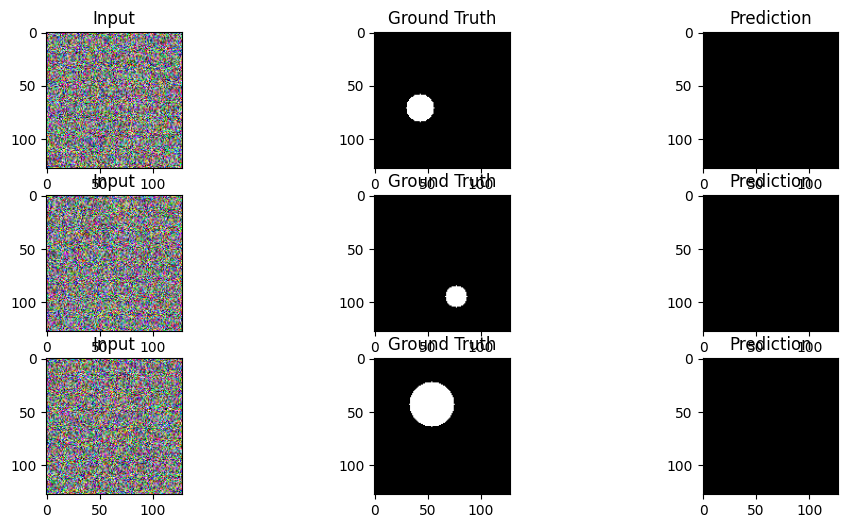

Mean IoU: 0.45739746


In [7]:
# Predict
preds = model.predict(X_test)
preds_binary = (preds > 0.5).astype(np.uint8)

# Visualize first 3 results
plt.figure(figsize=(12,6))
for i in range(3):
    plt.subplot(3,3,i*3+1)
    plt.imshow(X_test[i])
    plt.title("Input")
    plt.subplot(3,3,i*3+2)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.subplot(3,3,i*3+3)
    plt.imshow(preds_binary[i].squeeze(), cmap='gray')
    plt.title("Prediction")
plt.show()

# Compute Mean IoU
iou = MeanIoU(num_classes=2)
iou.update_state(y_test, preds_binary)
print("Mean IoU:", iou.result().numpy())
